# PKF-1 Example

The PFK-1 is a glycolising enzyme that catalyses the conversion of fructose-6-phosphate to fructose-1,6-bisphosphate using ATP.  
ATP is the substrate, but at high concentrations inhibits PFK-1 by binding to an allosteric site.  
ADP is an allosteric modulator, so can increase activity, but can also inhibit PKF-1 at high concentrations.


![PFK-1 chart](PFK-1.png)

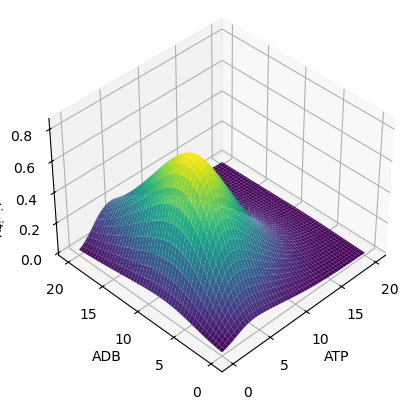

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from optobot.automate import OptimisationLoop

x = np.linspace(0,20,100)
y = np.linspace(0,20,100)

x_pdf = skewnorm.pdf(x, 4, loc = 2, scale = 6) * 10
y_pdf = skewnorm.pdf(y, 3, loc = 4, scale = 9) * 10

#dot product to get z
z = np.dot(x_pdf.reshape(-1,1), [y_pdf]).T
z
X, Y = np.meshgrid(x, y)

#Make a 3D plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, z,cmap='viridis',linewidth=0)
ax.set_xlabel('ATP')
ax.set_ylabel('ADB')
ax.set_zlabel('PFK-1 activity')
ax.view_init(elev=40, azim=-135)
plt.show()


Here is a function of what PFK-1 activity may look like with varying concentrations of ATP and ADB.  

In this experiment the researcher would use OptoBot to get a uniform range of concentrations for ATP and ADB, within a specified range. An assay would then be performed to measure activity, and the assay results can be typed into measurements.csv.  
In this example, the activity will instead be calculated using the function above.

In [110]:

from skopt.space import Real, Categorical

#PFK-1 activity with ATP and ADP

#define experiment name
experiment_name = "PFK1_activity"
data_storage_folder = "./example_data" 
name = f"{data_storage_folder}/{experiment_name}"

liquid_names = ['buffer', 'PFK-1', 'ATP', 'ADP']
measured_parameter_names = ['ATP_pdf', 'ADB_pdf']

def objective_function(liquid_volumes):
    """
    Returns negative product of the pdf for each ATP and ADP
    """

    return -(liquid_volumes[:,0] * liquid_volumes[:,1])

#for this example the volumes used as the measurements
def measurement_function(liquid_volumes, iteration_count, population_size, num_measured_parameters, exp_data_dir):
    """
    Returns the z value of the function above (activity of PFK-1)
    """
    #print(liquid_volumes)
    ATP_pdf = skewnorm.pdf(liquid_volumes[:,2], 4, loc = 2, scale = 6) * 10
    ADB_pdf = skewnorm.pdf(liquid_volumes[:,3], 3, loc = 4, scale = 9) * 10
    return np.vstack([ATP_pdf, ADB_pdf]).T

wellplate_locs = [5, 8]
num_iterations = 4
population_size = 48
name = 'PFK-1 activity'

#search space for the volumes of the liquids, not including buffer
#fixed volume of PFK-1
search_space = [
    Categorical([20.0]),   #PFK-1 amount is fixed   
    Real(0.0, 20.0),  
    Real(0.0, 20.0)         
]
#total volume in each well
total_volume = 60.0

# Define the automated optimisation loop.
model = OptimisationLoop(
    objective_function=objective_function,
    liquid_names=liquid_names,
    measured_parameter_names=measured_parameter_names,
    target_measurement=None,
    population_size=population_size,
    name=name,
    measurement_function=measurement_function,
    wellplate_locs=wellplate_locs,
    total_volume=total_volume,
)

# Start the optimisation loop.
# In this experiment, Guassian Process is used.
model.optimise(search_space, optimiser="GP", num_iterations=num_iterations)


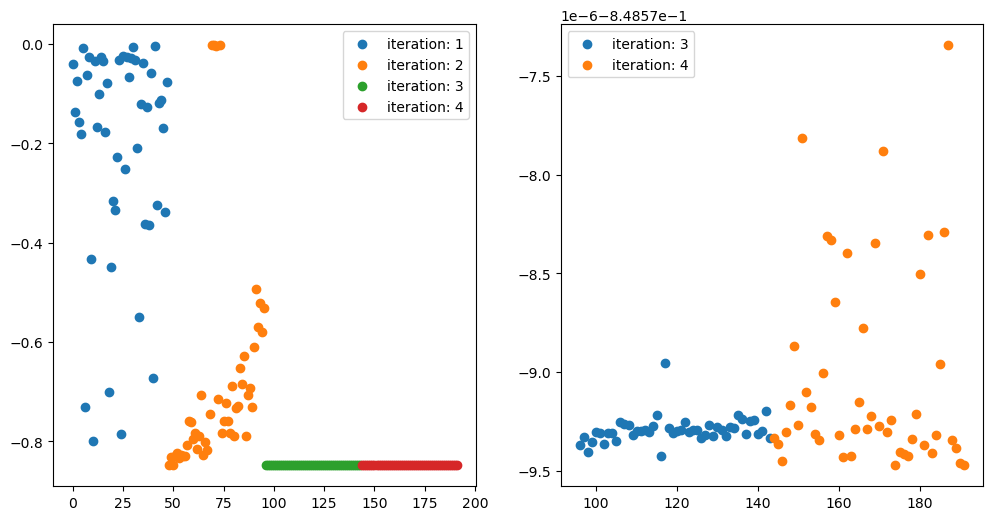

In [115]:
import pandas as pd

all_data = pd.read_csv('PFK-1 activity_Mon-07-Apr-2025-at-03-09-11PM/all_data.csv')
errors = all_data['error'].values
fig, ax = plt.subplots(1, 2, figsize = [12,6])
for i in range(num_iterations):
    start = i*population_size
    end = start+population_size
    ax[0].scatter(np.arange(start, end), errors[start:end], label = f'iteration: {i+1}')
for i in range(2,4):
    start = i*population_size
    end = start+population_size
    ax[1].scatter(np.arange(start, end), errors[start:end], label = f'iteration: {i+1}')
ax[0].legend()
ax[1].legend()
plt.show()

The optimisation algorithm guesses the underlying function from the previous measurements, and on each iteration has a more accurate guess for the maximum.  
After 2 iterations the search has a much smaller range, and the predictions are more varied for iteration 4 than iteration 3.

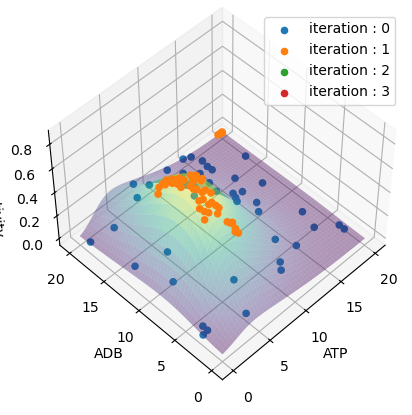

In [120]:
vol_ATP = all_data['vol_ATP'].values
vol_ADP = all_data['vol_ADP'].values
exp_z = -errors

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, z,cmap='viridis',linewidth=0, alpha=0.4)
for i in range(num_iterations):
    start = i*population_size
    end = start+population_size
    ax.scatter(vol_ATP[start:end], vol_ADP[start:end], exp_z[start:end], alpha=1.0, label = f'iteration : {i}')
ax.set_xlabel('ATP')
ax.set_ylabel('ADB')
ax.set_zlabel('PFK-1 activity')
ax.view_init(elev=50, azim=-135)
ax.legend()
plt.show()



On the earlier iterations the search is spread out the search space, and in the later iterations it is focused on the maximum.

In [121]:
optimal_well = all_data.iloc[np.where(all_data['error'] == np.min(all_data['error']))]

In [122]:
optimal_well

,Unnamed: 0,iteration_number,vol_buffer,vol_PFK-1,vol_ATP,vol_ADP,ATP_pdf,ADB_pdf,error
174,174,4.0,27.238291,20.0,4.501433,8.260276,1.160973,0.730921,-0.848579


The optimal ATP and ADP volumes found by this experiment are 4.50143 and 8.260276, respectively.